In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import os
from glob import glob

In [2]:
srcfolder = 'src'
folder = 'out'
try:
    os.mkdir(srcfolder + os.sep + folder)
except OSError:
    print 'Can\'t create out folder. Maybe it exists? pass'
    pass

Can't create out folder. Maybe it exists? pass


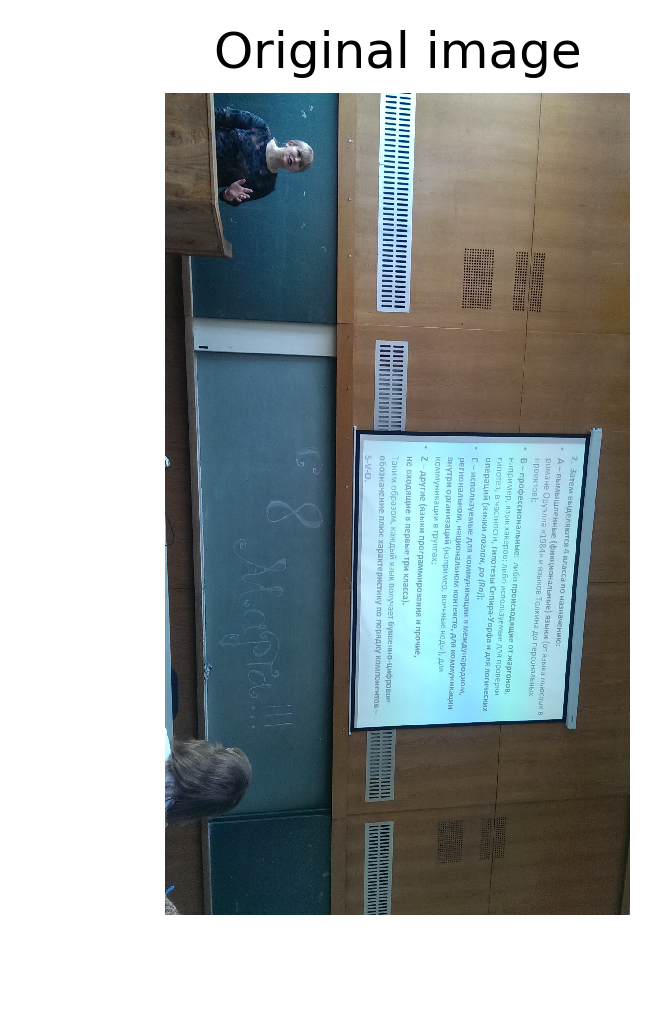

src\2016-03-09 15.14.29.jpg : (1520L, 2688L, 3L) => [10.752  6.08 ]
Trying to fix zeros on 775 :
	[-0.0125      0.          0.00657895]  -> 
	[-1.25000000e-02 -8.22368421e-05  6.57894737e-03]
borders:  6 [0, 526, 775, 844, 1128, 2058]


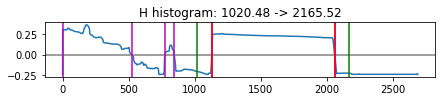

borders:  2 [195, 888]


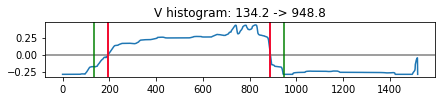

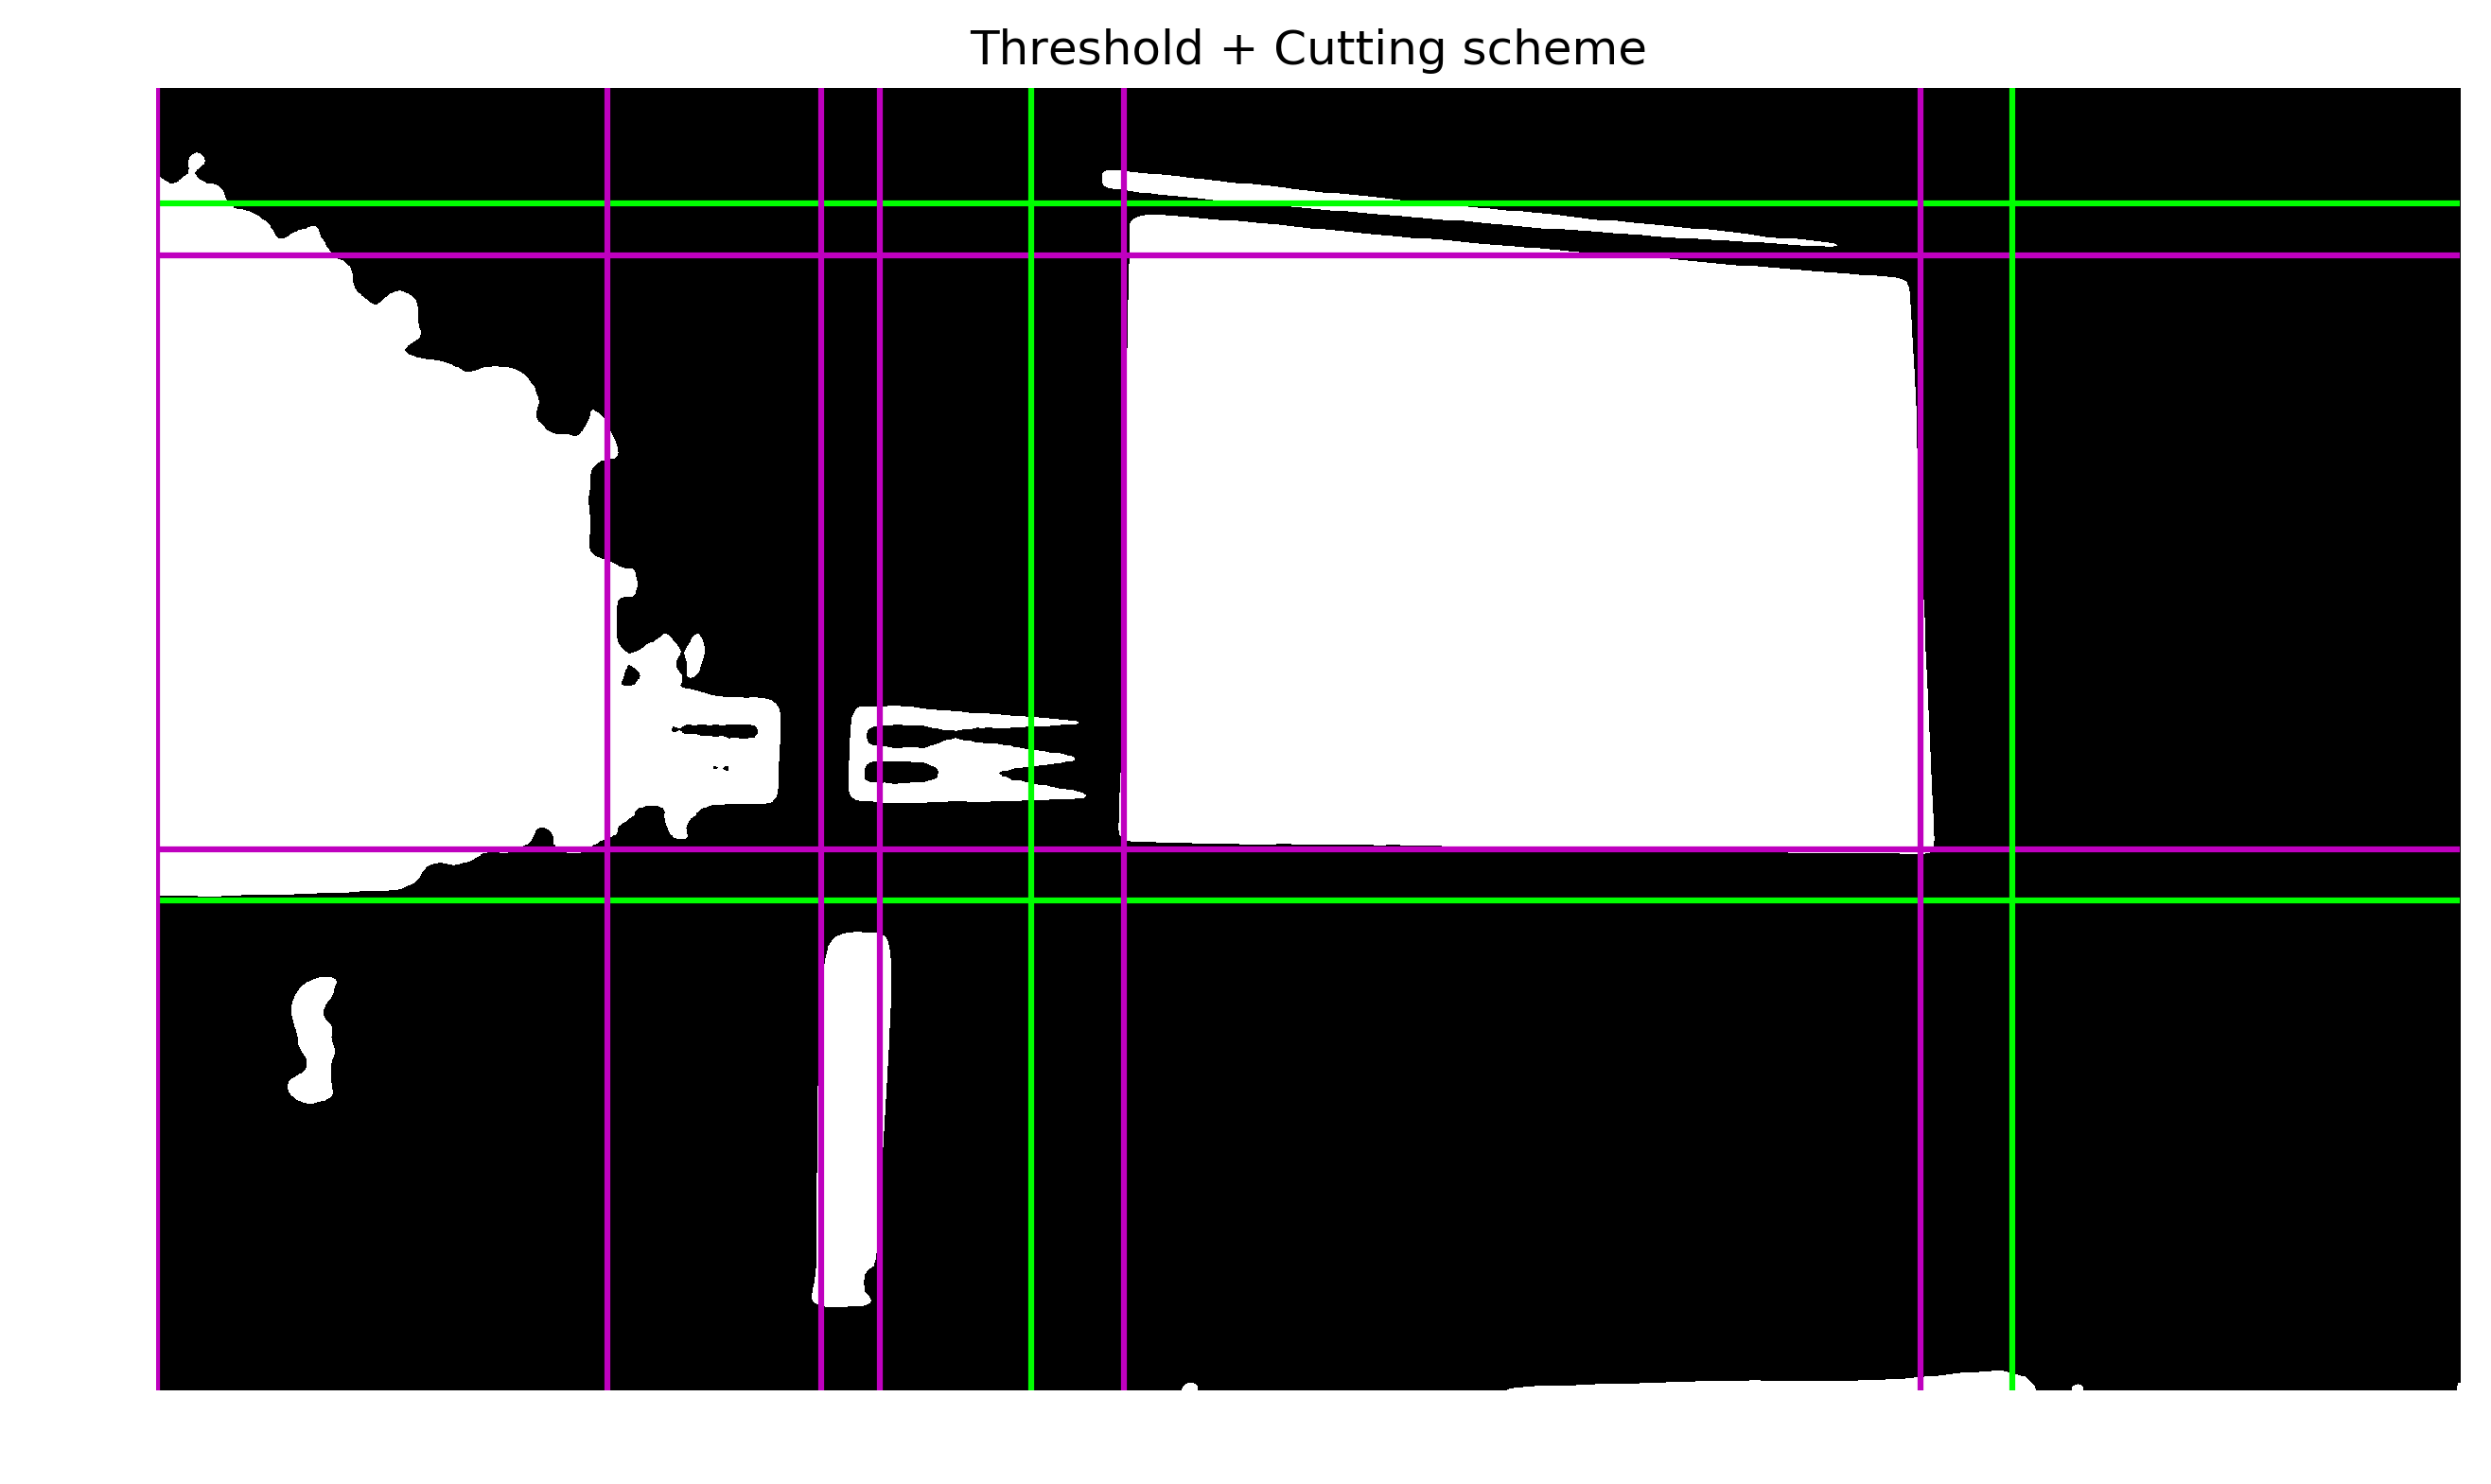

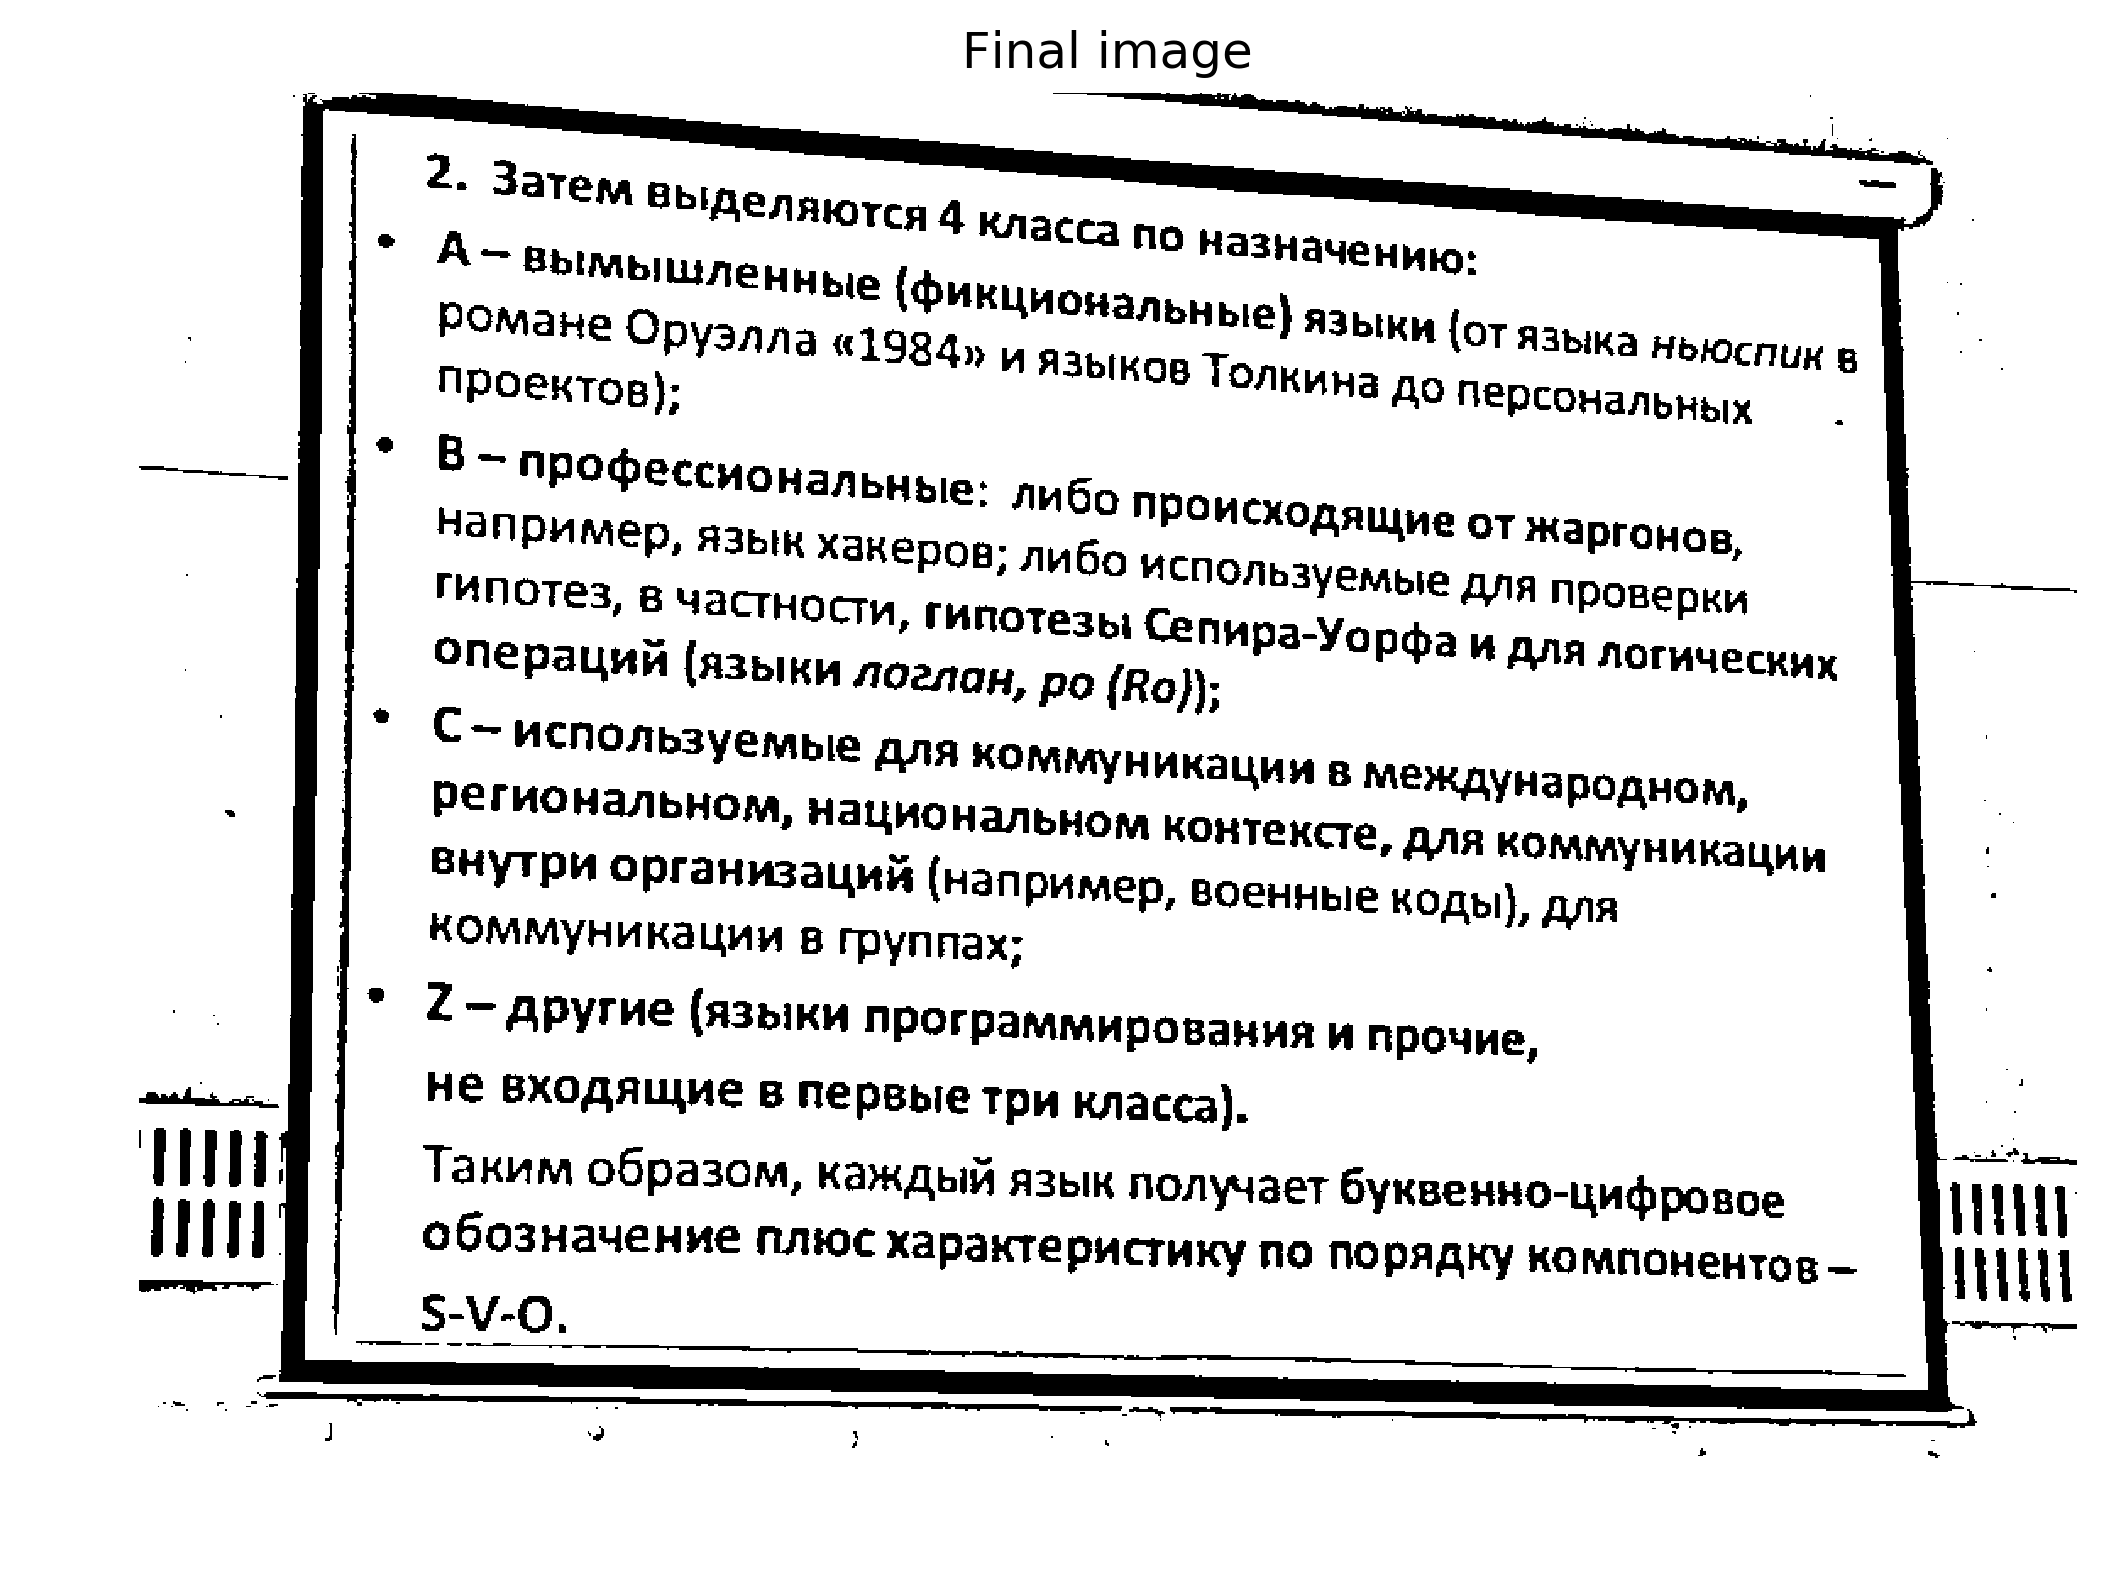

In [33]:
for f in sorted(glob(srcfolder + os.sep + '*.jpg')):
    orig = cv2.imread(f)
    
    plt.figure(figsize=np.array(orig.shape)[1::-1]/600, dpi=300)
    plt.imshow(orig[:,:,::-1], zorder=-100)
    plt.axis('off')
    plt.title('Original image')
    plt.show()
    
    if orig.shape[0] > orig.shape[1]:   # rotate if necessary
        orig = np.rot90(orig)
    size = np.array(orig.shape)[1::-1]
    figsize = size / 250.
    print f, ':', orig.shape, '=>', figsize

    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (49, 49), 0)
    ret, th = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    verhist = np.sum(th, axis=0) / 255. / size[1]
    horhist = np.sum(th, axis=1) / 255. / size[0]
    
    def borders(hist, d, frac=0.5, error=0.04):
        '''d - direction; is in ('h','v') interval'''
        plt.figure(figsize=(7,1))
        plt.plot(hist)
        
        x = np.where(hist > frac * np.max(hist))
        xmin, xmax = np.min(x), np.max(x)
        
        plt.axvline(xmin, c='r'); plt.axvline(xmax, c='r')
        xmin -= error * len(hist); xmax += error * len(hist)
        
        if xmin < 0: xmin = 0
        if xmax > len(hist)-1: xmax = len(hist)-1
        
        plt.title(d.upper() + ' histogram: ' + str(xmin) + ' -> ' + str(xmax))
        plt.axvline(xmin, c='g'); plt.axvline(xmax, c='g')
        plt.show(); plt.close()
        return int(xmin), int(xmax), (int(xmin), int(xmax))
    
    def bordersx(hist, d, frac=0.4, error=0.04):
        hist[0] = 0
        hist[-1] = 0
        hist -= frac * np.max(hist)
        
        plt.figure(figsize=(7,1))
        plt.plot(hist)
        plt.axhline(0, c='gray')
        
        for i in xrange(1, hist.shape[0] - 1):
            if hist[i] == 0:
                print 'Trying to fix zeros on', i, ':\n\t', hist[i-1:i+2],
                hist[i] = hist[i-1] * hist[i+1]
                print ' -> \n\t', hist[i-1:i+2]
        
        b = list()
        for i in xrange(0, hist.shape[0] - 1):
            if hist[i] * hist[i+1] <= 0:
                b.append(i)                
                
        print 'borders: ', len(b), b
        for pt in b:
            plt.axvline(pt, c='m')
            
        xmin = 0
        xmax = len(hist) - 1
        mdx = 0
        for i in range(0,len(b),2):
            if b[i+1] - b[i] > mdx:
                mdx = b[i+1] - b[i]
                xmin = b[i]
                xmax = b[i+1]        
        
        plt.axvline(xmin, c='r'); plt.axvline(xmax, c='r')
        xmin -= error * len(hist); xmax += error * len(hist)
        
        if xmin < 0: xmin = 0
        if xmax > len(hist)-1: xmax = len(hist)-1
        
        plt.title(d.upper() + ' histogram: ' + str(xmin) + ' -> ' + str(xmax))
        plt.axvline(xmin, c='g'); plt.axvline(xmax, c='g')
        plt.show(); plt.close()
        return int(xmin), int(xmax), b
    
    xmin, xmax, bx = bordersx(verhist, 'h')
    ymin, ymax, by = bordersx(horhist, 'v')
    
    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(th, cmap='gray', zorder=-100)
    plt.axhline(ymin, c='lime', lw=1.5); plt.axhline(ymax, c='lime', lw=1.5)
    for b in by: plt.axhline(b, c='m')
    plt.axvline(xmin, c='lime', lw=1.5); plt.axvline(xmax, c='lime', lw=1.5)
    for b in bx: plt.axvline(b, c='m')
    plt.axis('off')
    plt.title('Threshold + Cutting scheme')
    plt.show()
    
    orig = orig[ymin:ymax, xmin:xmax]
       
    th2 = cv2.adaptiveThreshold(gray[ymin:ymax, xmin:xmax], 
                                150, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                cv2.THRESH_BINARY, 
                                49, 
                                15)
    
    try:
        ret, th3 = cv2.threshold(th2, 100, 255, cv2.THRESH_BINARY)
    except:
        th3 = gray[ymin:ymax, xmin:xmax]
    
    plt.figure(figsize=figsize, dpi=300)
    plt.imshow(th3, cmap='gray', zorder=-100)
    plt.axis('off')
    plt.title('Final image')
    plt.show()
    print '='*100
    
    cv2.imwrite(srcfolder + os.sep + folder + os.sep + f.split('/')[-1], th3)